In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import scipy.io as sio
from keras.layers import Lambda
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Conv3D, AveragePooling2D, AveragePooling3D, MaxPooling2D
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import TimeDistributed, LSTM, Bidirectional, ConvLSTM2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pickle

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
dataPath = '../data/spectral_feat_tensor_full_with_full_labels_images_3dcnn_norm.mat'
savePath = '../Results/CNN_LSTM/'

architectures = ['Plain_LSTM', '2D-CNN_LSTM_Bashivan', '2D-CNN_LSTM_Our', 'Conv_LSTM', 'BiLSTM'] 

arch = 'Conv_LSTM'

experiment = 'HVLV' # HVLV or HALA or Multi

data = 'NC' # FUll or PD or NC

filename = savePath+arch+"_"+experiment+"_2L"+"_"+data+".mat"

if experiment == 'HVLV':
    title = 'HV vs LV Classification '+'('+data+')'
    conf_mat = np.zeros((2,2))
    conf_mat_labels = [0,1]
    plot_labels = ['LV', 'HV']
    
elif experiment == 'HALA':
    title = 'HA vs LA Classification '+'('+data+')'
    conf_mat = np.zeros((2,2))
    conf_mat_labels = [0,1]
    plot_labels = ['LA', 'HA']
    
elif experiment == 'Multi':
    title = 'Categorical Emotion Classification '+'('+data+')'
    conf_mat = np.zeros((6,6))
    conf_mat_labels = [1, 2, 3, 4, 5, 0]
    plot_labels = ['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger']
    
else:
    raise ValueError('Expecting HVLV, HALA, Multi only.')

nb_filters = [16, 32, 32, 64, 128]
#nb_filters = [64, 64]
kernel_size = 3
pool_size = 2
stride_size = 2
padding = 'same'
weight_decay = 0.000001
dense_layer_neuron_num = 512
optimizer='Adam'
init_mode = 'he_normal'
activation='relu'
learn_rate = 0.0001
momentum = 0.8
dropout_rate = 0.5
num_units = 512
batch_size = 32
epochs = 30
foldNum = 10

'''
with open(dataPath, 'rb') as pkl:
    data = pickle.load(pkl)
'''

matContent = sio.loadmat(dataPath)
features = matContent[data.lower()+'_feat_img'] #full_feat_img or pd_feat_img or nc_feat_img
labels = np.squeeze(matContent[data.lower()+'_'+experiment.lower()+'_'+'labels']) # eg pd_hvlv_labels
 
features = np.swapaxes(features,2,4)
features = np.swapaxes(features,2,3)

if experiment == 'Multi':
    labels[labels == 6]=0

#labels[labels < 0] = 0
#labels = labels.astype(int)

# randomise the sample sequence
rand_order = np.arange(features.shape[0])
np.random.shuffle(rand_order)
features = features[rand_order,]
labels = np.squeeze(labels[rand_order,])
class_num = np.size(np.unique(labels))
labels_categorical = np_utils.to_categorical(labels)
del matContent
#del data

print('Features shape:',features.shape)
print('Number of classes:',class_num)
print('Labels shape:', labels.shape)

Features shape: (7412, 5, 32, 32, 3)
Number of classes: 2
Labels shape: (7412,)


In [3]:
def plain_lstm_model(optimizer, activation, num_units, dropout_rate, learn_rate):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(num_units, activation=activation, return_sequences=True, 
                   input_shape=(features.shape[1],features.shape[2])))
    model.add(LSTM(num_units, activation=activation, return_sequences=True))
    model.add(LSTM(num_units, activation=activation, return_sequences=False))
    model.add(Dense(dense_layer_neuron_num, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(class_num, activation='softmax'))
    #model.add(Activation('softmax'))
    if optimizer == 'Adagrad':
        opt = Adagrad(learning_rate=learn_rate)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=learn_rate)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [4]:
def cnn2d_lstm_model_bashivan(optimizer, activation, kernel_size, padding, init_mode,
                              pool_size, stride_size, num_units, dense_layer_neuron_num,
                              nb_filters, class_num, dropout_rate, learn_rate):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding, 
                                     activation=activation, trainable=True), 
                              input_shape=(features.shape[1], features.shape[2], 
                                           features.shape[3], features.shape[4])))
    model.add(TimeDistributed(Conv2D(filters=nb_filters[1], kernel_size=kernel_size,
                                     padding=padding, activation=activation,
                                     kernel_initializer=init_mode, trainable=True)))  
    model.add(TimeDistributed(Conv2D(filters=nb_filters[2], kernel_size=kernel_size,
                                     padding=padding, activation=activation,
                                     kernel_initializer=init_mode, trainable=True)))
    model.add(TimeDistributed(Conv2D(filters=nb_filters[3], kernel_size=kernel_size,
                                     padding=padding, activation=activation,
                                     kernel_initializer=init_mode, trainable=True)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size, strides=stride_size, padding=padding)))
    model.add(TimeDistributed(Conv2D(filters=nb_filters[4], kernel_size=kernel_size,
                                     padding=padding, activation=activation,
                                     kernel_initializer=init_mode, trainable=True)))
    model.add(TimeDistributed(Conv2D(filters=nb_filters[5], kernel_size=kernel_size,
                                     padding=padding, activation=activation,
                                     kernel_initializer=init_mode, trainable=True)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size, strides=stride_size, padding=padding)))
    model.add(TimeDistributed(Conv2D(filters=nb_filters[6], kernel_size=kernel_size,
                                     padding=padding, activation=activation,
                                     kernel_initializer=init_mode, trainable=True)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=pool_size, strides=stride_size, padding=padding)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=num_units))
    #model.add(Dropout(dropout_rate))
    model.add(Dense(dense_layer_neuron_num))
    model.add(Dropout(dropout_rate))
    model.add(Dense(class_num, activation='softmax'))
    if optimizer == 'SGD':
        opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=learn_rate)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [5]:
def cnn2d_lstm_model_our(optimizer, activation, kernel_size, padding, init_mode,
                         pool_size, stride_size, num_units, dense_layer_neuron_num,
                         nb_filters, class_num, dropout_rate, learn_rate):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding, 
                                     activation=activation, trainable=True), 
                              input_shape=(features.shape[1], features.shape[2], 
                                           features.shape[3], features.shape[4])))
    model.add(TimeDistributed(AveragePooling3D(pool_size=pool_size, strides=stride_size, padding=padding)))
    model.add(TimeDistributed(Conv2D(filters=nb_filters[1], kernel_size=kernel_size,
                                     padding=padding, activation=activation, 
                                     kernel_initializer=init_mode, trainable=True)))
    model.add(TimeDistributed(AveragePooling3D(pool_size=pool_size, strides=stride_size, padding=padding)))
    model.add(TimeDistributed(Conv2D(filters=nb_filters[2], kernel_size=kernel_size, 
                                     padding=padding, activation=activation,
                                     kernel_initializer=init_mode, trainable=True)))
    model.add(TimeDistributed(AveragePooling3D(pool_size=pool_size, strides=stride_size, padding=padding)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=num_units))
    #model.add(Dropout(dropout_rate))
    model.add(Dense(dense_layer_neuron_num))
    model.add(Dropout(dropout_rate))
    model.add(Dense(class_num, activation='softmax'))
    if optimizer == 'SGD':
        opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=learn_rate)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [6]:
def conv_lstm_model(optimizer, activation, kernel_size, padding, init_mode,
                    pool_size, stride_size, num_units, dense_layer_neuron_num,
                    nb_filters, class_num, dropout_rate, learn_rate):
    model = Sequential()
    model.add(ConvLSTM2D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding, activation=activation, 
                         kernel_initializer=init_mode, return_sequences=True,
                         input_shape=(features.shape[1], features.shape[2], features.shape[3], features.shape[4])))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(filters=nb_filters[1], kernel_size=kernel_size, padding=padding, activation=activation, 
                         kernel_initializer=init_mode, return_sequences=True))
    model.add(BatchNormalization())
    #model.add(ConvLSTM2D(filters=nb_filters[2], kernel_size=kernel_size, padding=padding, activation=activation, 
    #                     kernel_initializer=init_mode, return_sequences=False))
    #model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_layer_neuron_num, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(class_num, activation='softmax'))
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learn_rate)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [7]:
def bilstm_model(optimizer, activation, kernel_size, padding, init_mode,
                 pool_size, stride_size, num_units, dense_layer_neuron_num,
                 nb_filters, class_num, dropout_rate, learn_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(num_units, return_sequences=True, activation=activation),
                            input_shape=(features.shape[1],features.shape[2])))
    model.add(Bidirectional(LSTM(num_units)))
    #model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_layer_neuron_num, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(class_num, activation='softmax'))
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learn_rate)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 5, 32, 32, 16)     11008     
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 32, 32, 16)     64        
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 5, 32, 32, 32)     55424     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 32, 32, 32)     128       
_________________________________________________________________
flatten (Flatten)            (None, 163840)            0         
_________________________________________________________________
dropout (Dropout)            (None, 163840)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               8

Epoch 15/30
188/188 - 11s - loss: 0.3061 - accuracy: 0.8599 - val_loss: 0.4426 - val_accuracy: 0.8036
Epoch 16/30
188/188 - 11s - loss: 0.3058 - accuracy: 0.8614 - val_loss: 0.4826 - val_accuracy: 0.8006
Epoch 17/30
188/188 - 11s - loss: 0.2836 - accuracy: 0.8697 - val_loss: 0.4627 - val_accuracy: 0.8156
Epoch 18/30
188/188 - 11s - loss: 0.2593 - accuracy: 0.8794 - val_loss: 0.4537 - val_accuracy: 0.7916
Epoch 19/30
188/188 - 11s - loss: 0.2574 - accuracy: 0.8789 - val_loss: 0.4667 - val_accuracy: 0.8216
Epoch 20/30
188/188 - 11s - loss: 0.2448 - accuracy: 0.8907 - val_loss: 0.5165 - val_accuracy: 0.8051
Epoch 21/30
188/188 - 11s - loss: 0.2524 - accuracy: 0.8847 - val_loss: 0.4749 - val_accuracy: 0.8216
Epoch 22/30
188/188 - 11s - loss: 0.2298 - accuracy: 0.8962 - val_loss: 0.5000 - val_accuracy: 0.8096
Epoch 23/30
188/188 - 11s - loss: 0.2300 - accuracy: 0.8962 - val_loss: 0.4673 - val_accuracy: 0.8216
Epoch 24/30
188/188 - 11s - loss: 0.2186 - accuracy: 0.9000 - val_loss: 0.4555 - v

Epoch 3/30
188/188 - 11s - loss: 0.5105 - accuracy: 0.7441 - val_loss: 0.4826 - val_accuracy: 0.7620
Epoch 4/30
188/188 - 11s - loss: 0.4853 - accuracy: 0.7588 - val_loss: 0.4679 - val_accuracy: 0.7575
Epoch 5/30
188/188 - 11s - loss: 0.4519 - accuracy: 0.7789 - val_loss: 0.4860 - val_accuracy: 0.7620
Epoch 6/30
188/188 - 11s - loss: 0.4309 - accuracy: 0.7901 - val_loss: 0.4675 - val_accuracy: 0.7605
Epoch 7/30
188/188 - 11s - loss: 0.3970 - accuracy: 0.8101 - val_loss: 0.4583 - val_accuracy: 0.7964
Epoch 8/30
188/188 - 11s - loss: 0.3833 - accuracy: 0.8161 - val_loss: 0.4272 - val_accuracy: 0.7979
Epoch 9/30
188/188 - 11s - loss: 0.3594 - accuracy: 0.8256 - val_loss: 0.4396 - val_accuracy: 0.7994
Epoch 10/30
188/188 - 11s - loss: 0.3499 - accuracy: 0.8339 - val_loss: 0.4367 - val_accuracy: 0.8114
Epoch 11/30
188/188 - 11s - loss: 0.3279 - accuracy: 0.8431 - val_loss: 0.4509 - val_accuracy: 0.7964
Epoch 12/30
188/188 - 11s - loss: 0.3101 - accuracy: 0.8497 - val_loss: 0.4569 - val_accu

Epoch 1/30
188/188 - 11s - loss: 1.1148 - accuracy: 0.6570 - val_loss: 0.5732 - val_accuracy: 0.7305
Epoch 2/30
188/188 - 11s - loss: 0.5896 - accuracy: 0.7136 - val_loss: 0.4915 - val_accuracy: 0.7620
Epoch 3/30
188/188 - 11s - loss: 0.5275 - accuracy: 0.7391 - val_loss: 0.4969 - val_accuracy: 0.7530
Epoch 4/30
188/188 - 11s - loss: 0.4955 - accuracy: 0.7545 - val_loss: 0.4723 - val_accuracy: 0.7590
Epoch 5/30
188/188 - 11s - loss: 0.4551 - accuracy: 0.7806 - val_loss: 0.4411 - val_accuracy: 0.7859
Epoch 6/30
188/188 - 11s - loss: 0.4359 - accuracy: 0.7921 - val_loss: 0.4092 - val_accuracy: 0.7994
Epoch 7/30
188/188 - 11s - loss: 0.4088 - accuracy: 0.8028 - val_loss: 0.3997 - val_accuracy: 0.8174
Epoch 8/30
188/188 - 11s - loss: 0.3862 - accuracy: 0.8183 - val_loss: 0.4024 - val_accuracy: 0.8009
Epoch 9/30
188/188 - 11s - loss: 0.3710 - accuracy: 0.8258 - val_loss: 0.3842 - val_accuracy: 0.8009
Epoch 10/30
188/188 - 11s - loss: 0.3612 - accuracy: 0.8298 - val_loss: 0.3909 - val_accura

Epoch 1/30
188/188 - 11s - loss: 1.0941 - accuracy: 0.6495 - val_loss: 0.5767 - val_accuracy: 0.7216
Epoch 2/30
188/188 - 11s - loss: 0.6024 - accuracy: 0.7093 - val_loss: 0.5035 - val_accuracy: 0.7365
Epoch 3/30
188/188 - 11s - loss: 0.5330 - accuracy: 0.7335 - val_loss: 0.4846 - val_accuracy: 0.7545
Epoch 4/30
188/188 - 11s - loss: 0.4897 - accuracy: 0.7573 - val_loss: 0.4950 - val_accuracy: 0.7575
Epoch 5/30
188/188 - 11s - loss: 0.4636 - accuracy: 0.7779 - val_loss: 0.4409 - val_accuracy: 0.7754
Epoch 6/30
188/188 - 11s - loss: 0.4480 - accuracy: 0.7848 - val_loss: 0.4381 - val_accuracy: 0.7814
Epoch 7/30
188/188 - 11s - loss: 0.4129 - accuracy: 0.8009 - val_loss: 0.4241 - val_accuracy: 0.7814
Epoch 8/30
188/188 - 11s - loss: 0.3890 - accuracy: 0.8113 - val_loss: 0.4041 - val_accuracy: 0.8009
Epoch 9/30
188/188 - 11s - loss: 0.3607 - accuracy: 0.8268 - val_loss: 0.4338 - val_accuracy: 0.7769
Epoch 10/30
188/188 - 11s - loss: 0.3558 - accuracy: 0.8314 - val_loss: 0.4108 - val_accura

Epoch 1/30
188/188 - 12s - loss: 1.0178 - accuracy: 0.6578 - val_loss: 0.5938 - val_accuracy: 0.7171
Epoch 2/30
188/188 - 11s - loss: 0.6102 - accuracy: 0.7001 - val_loss: 0.5113 - val_accuracy: 0.7350
Epoch 3/30
188/188 - 11s - loss: 0.5486 - accuracy: 0.7220 - val_loss: 0.4745 - val_accuracy: 0.7575
Epoch 4/30
188/188 - 11s - loss: 0.4984 - accuracy: 0.7466 - val_loss: 0.4783 - val_accuracy: 0.7545
Epoch 5/30
188/188 - 11s - loss: 0.4739 - accuracy: 0.7628 - val_loss: 0.4536 - val_accuracy: 0.7710
Epoch 6/30
188/188 - 11s - loss: 0.4473 - accuracy: 0.7759 - val_loss: 0.4484 - val_accuracy: 0.7844
Epoch 7/30
188/188 - 11s - loss: 0.4212 - accuracy: 0.7968 - val_loss: 0.4291 - val_accuracy: 0.7919
Epoch 8/30
188/188 - 11s - loss: 0.4097 - accuracy: 0.7956 - val_loss: 0.4327 - val_accuracy: 0.7979
Epoch 9/30
188/188 - 11s - loss: 0.3850 - accuracy: 0.8168 - val_loss: 0.4129 - val_accuracy: 0.7949
Epoch 10/30
188/188 - 11s - loss: 0.3744 - accuracy: 0.8233 - val_loss: 0.4374 - val_accura

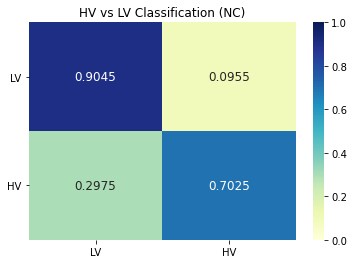

Mean and std of F1 MACRO is 0.8114 +- 0.0184
Mean and std of F1 WEIGHTED is 0.8325 +- 0.0157
Mean and std of accuracy is 0.8353 +- 0.0148


In [8]:

f = 0
f1_MacroNet = np.zeros([foldNum,]) 
f1_weightedNet = np.zeros([foldNum,])
precisionNet = np.zeros([foldNum,])
recallNet = np.zeros([foldNum,])
accNet = np.zeros([foldNum,])

kfold = StratifiedKFold(n_splits=foldNum, random_state=111, shuffle=True)

if arch == 'Plain_LSTM' or arch == 'BiLSTM':
    feat_shape = features.shape
    features = np.reshape(features, (feat_shape[0], feat_shape[1], feat_shape[2]*feat_shape[3]*feat_shape[4]))
    print("entering if loop")
else:
    pass

for train, test in kfold.split(features, labels):
    
    tf.keras.backend.clear_session()
    if arch == 'Plain_LSTM':
        trainingFeatures = features[train,:,:]
        testFeatures = features[test,:,:]
        lstm = plain_lstm_model(optimizer, activation, num_units, dropout_rate, learn_rate)
    elif arch == '2D-CNN_LSTM_Bashivan':
        trainingFeatures = features[train,:,:,:,:]
        testFeatures = features[test,:,:,:,:]
        lstm = cnn2d_lstm_model_bashivan(optimizer, activation, kernel_size, padding, init_mode, 
                                         pool_size, stride_size, num_units, dense_layer_neuron_num,
                                         nb_filters, class_num, dropout_rate, learn_rate)
    elif arch == '2D-CNN_LSTM_Our':
        trainingFeatures = features[train,:,:,:,:]
        testFeatures = features[test,:,:,:,:]
        lstm = cnn2d_lstm_model_our(optimizer, activation, kernel_size, padding, init_mode,
                                    pool_size, stride_size, num_units, dense_layer_neuron_num,
                                    nb_filters, class_num, dropout_rate, learn_rate)
    elif arch == 'Conv_LSTM':
        trainingFeatures = features[train,:,:,:,:]
        testFeatures = features[test,:,:,:,:]
        lstm = conv_lstm_model(optimizer, activation, kernel_size, padding, init_mode,
                               pool_size, stride_size, num_units, dense_layer_neuron_num,
                               nb_filters, class_num, dropout_rate, learn_rate)
    elif arch == 'BiLSTM':
        trainingFeatures = features[train,:,:]
        testFeatures = features[test,:,:]
        lstm = bilstm_model(optimizer, activation, kernel_size, padding, init_mode,
                            pool_size, stride_size, num_units, dense_layer_neuron_num,
                            nb_filters, class_num, dropout_rate, learn_rate)
    
    lstm.summary()
    lstm.fit(trainingFeatures, labels_categorical[train,:], batch_size=batch_size,
             epochs=epochs, verbose=2, validation_split=0.1)
    predicted_labelsNet = lstm.predict_classes(testFeatures, verbose=0)
    #predicted_probsNet = lstm.predict_proba(testFeatures,batch_size=1,verbose=0)
    cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=conf_mat_labels)
    conf_mat = conf_mat+cm
    
    precisionNet[f] = precision_score(labels[test,], predicted_labelsNet, average='macro')
    recallNet[f] = recall_score(labels[test,], predicted_labelsNet, average='macro')
    f1_MacroNet[f] = f1_score(labels[test,], predicted_labelsNet, average='macro')
    f1_weightedNet[f] = f1_score(labels[test,], predicted_labelsNet, average='weighted')
    accNet[f] = accuracy_score(labels[test,], predicted_labelsNet)
    print(experiment + '_CNN_LSTM: Fold %d : f1_macroscore: %.4f' % (f + 1, f1_MacroNet[f]))
    print(experiment + '_CNN_LSTM: Fold %d : f1_weightedscore: %.4f' % (f + 1, f1_weightedNet[f]))
    print(experiment + '_CNN_LSTM: Fold %d : acc: %.4f' % (f + 1, accNet[f]))
    f += 1

conf_mat /= conf_mat.sum(axis=1, keepdims = True)
if experiment == 'Multi':
    fig, ax = plt.subplots(figsize=(10,8))

ax = sns.heatmap(conf_mat, cmap='YlGnBu', annot = True, fmt='.4f', vmin=0, vmax=1, annot_kws = {'fontsize':12})
ax.set_yticklabels(plot_labels, rotation = 0)
ax.set_xticklabels(plot_labels, rotation = 0) 


ax.set_title(title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

# Save results
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat,
                       'experiment':experiment,'nb_filters':nb_filters,
                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,
                       'padding':padding, 'weight_decay':weight_decay,
                       'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs,
                       'lstm_num_units':num_units})
